<a href="https://colab.research.google.com/github/ElZho/Graduation-project-Predict-Disaster-tweets/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import gc


In [ ]:
from collections import defaultdict
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm.auto import tqdm

from IPython.display import clear_output
%matplotlib inline

In [ ]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification

In [ ]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Анализ данных

Смотрим пропуски

In [ ]:
#in train data in absolute value
clean_data.query('krit==1').isna().sum()

keyword              61
location           2533
text                  0
target                0
krit                  0
url                   0
hashtags           7613
location_clened    2533
country_en         5787
region_en          5796
city_en            5787
dtype: int64

In [ ]:
#in train data in persent
clean_data.query('krit==1').isna().sum()/clean_data.query('krit==1').shape[0]*100

keyword              0.801261
location            33.272035
text                 0.000000
target               0.000000
krit                 0.000000
url                  0.000000
hashtags           100.000000
location_clened     33.272035
country_en          76.014712
region_en           76.132931
city_en             76.014712
dtype: float64

In [ ]:
clean_data.query('krit==1').target.sum()

3271.0

In [ ]:
#in test data in absolute value
clean_data.query('krit==0').isna().sum()

keyword              26
location           1106
text                  0
target             3263
krit                  0
url                   0
hashtags           3263
location_clened    1106
country_en         2447
region_en          2456
city_en            2447
dtype: int64

In [ ]:
#in train data in persent
clean_data.query('krit==0').isna().sum()/clean_data.query('krit==0').shape[0]*100

keyword              0.796813
location            33.895188
text                 0.000000
target             100.000000
krit                 0.000000
url                  0.000000
hashtags           100.000000
location_clened     33.895188
country_en          74.992338
region_en           75.268158
city_en             74.992338
dtype: float64

##Построим карту

Скачаем гео данные и постараемся сопоставить с локацией.

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/geo.csv'
geo = pd.read_csv(path_to_data, sep=';')

In [ ]:
geo

,id,country_en,region_en,city_en,country,region,city,lat,lng,population
0,1,United Arab Emirates,Ra's al Khaymah,Ras al-Khaimah,Объединенные Арабские Эмираты,Ras al Khaimah,Рас-эль-Хайма,25.800693,55.976199,115949
1,2,United Arab Emirates,Dubai,Dubai,Объединенные Арабские Эмираты,Дубай,Дубай,25.204849,55.270783,1137347
2,3,United Arab Emirates,Ash Shariqah,Sharjah,Объединенные Арабские Эмираты,Шарджа,Шарджа,25.322327,55.513643,543733
3,4,United Arab Emirates,Al Fujayrah,Al Fujayrah,Объединенные Арабские Эмираты,Фьюджейра,Фьюджейра,25.411076,56.248228,62415
4,5,United Arab Emirates,Abu Dhabi,Al Ain,Объединенные Арабские Эмираты,Абу-Даби,Эль-Айн,24.130162,55.802312,408733
...,...,...,...,...,...,...,...,...,...,...
8444,8445,Zimbabwe,Harare,Harare,Зимбабве,Хараре,Хараре,-17.825166,31.033510,1542813
8445,8446,Zimbabwe,Midlands,Gweru,Зимбабве,Мидлендс,Гверу,-19.468531,29.812079,146073
8446,8447,Zimbabwe,Mashonaland West,Chinhoyi,Зимбабве,Западный Машоналенд,Чинхойи,-17.365266,30.193566,61739
8447,8448,Zimbabwe,Bulawayo,Bulawayo,Зимбабве,Булавайо,Булавайо,-20.132507,28.626479,699385


Переведем в нижний регистр

In [ ]:
geo['city_en']=geo['city_en'].str.lower()

Напишем функцию для чистки поля location

In [ ]:
def rename_citys(data):
  data['location'].replace('Chicago', 'chicago', inplace=True)
  data['location'].replace('Los Angeles', 'los angeles', inplace=True)
  data['location'].replace('London', 'london', inplace=True)
  data['location'].replace('Toronto', 'toronto', inplace=True)
  data['location'].replace('Seattle', 'seattle', inplace=True)
  data['location'].replace('texas', 'austin', inplace=True)  
  data['location'].replace('Jacksonville', 'jacksonville', inplace=True) 
  data['location'].replace('manchesantr', 'manchester', inplace=True) 
  data['location'].replace('ireland', 'dublin', inplace=True)
  data['location'].replace('india', 'mumbai', inplace=True)
  data['location'].replace('oklahoma', 'oklahoma city', inplace=True) 
  data['location'].replace('pennsylvania', 'philadelphia', inplace=True)
  data['location'].replace('Can Francisco', 'san francisco', inplace=True)
  data['location'].replace('Los Angeles', 'east los angeles', inplace=True)
  data['location'].replace('New-York', 'new york city', inplace=True)
  data['location'].replace('los angeles', 'east los angeles', inplace=True)
  data['location'].replace('Washington', 'washington, d.c.', inplace=True)
  data['location'].replace('us', 'new york city', inplace=True)
  data['location'].replace('nigeria', 'lagos', inplace=True)
  data['location'].replace('scotland', 'glasgow', inplace=True)
  data['location'].replace('indonesia', 'jakarta', inplace=True)
  data['location'].replace(r'massachusetts', 'massachusetts', inplace=True)
  data['location'].replace('kansas', 'kansas city', inplace=True)
  data['location'].replace('colorado', 'denver', inplace=True)
  data['location'].replace('tennessee', 'nashville', inplace=True)
  data['location'].replace('michigan', 'denver', inplace=True)
  data['location'].replace('new jersey', 'trenton', inplace=True)
  data['location'].replace('china', 'beijing', inplace=True)
  data['location'].replace('oregon', 'portland', inplace=True)
  data['location'].replace('indiana', 'indianapolis', inplace=True)
  
  data['location'].replace('north carolina', 'raleigh', inplace=True)
  data['location'].replace('denverlorado', 'denver', inplace=True) 
  data['location'].replace('south africa', 'pretoria', inplace=True)

  data['location'].replace('new jersey ', 'trenton', inplace=True)
  data['location'].replace('calgary, alberta', 'calgary', inplace=True)
  data['location'].replace('new hampshire', 'concord', inplace=True)
  data['location'].replace('wisconsin', 'milwaukee', inplace=True)
  data['location'].replace('southern california', 'los angeles', inplace=True)
  data['location'].replace('maryland', 'baltimore', inplace=True)
  data['location'].replace('morioh, japan', 'moriya', inplace=True)
  data['location'].replace('italy', 'milano', inplace=True)
  data['location'].replace('dublin, ireland', 'dublin', inplace=True)
  data['location'].replace('singapore', 'singapore', inplace=True)
  data['location'].replace('pakisantn', 'islamabad', inplace=True)
  data['location'].replace('portlandegon', 'portland', inplace=True)
  data['location'].replace('africa', 'mombasa', inplace=True)


  return data

In [ ]:
clean_data=rename_citys(clean_data)

Отберем данные, где есть локация, для представления на карте

In [ ]:
df_plot_geo=clean_data[~clean_data.location.isna()]

Т.к. названия городов присутствуют в нескольких странах отберем интересующие нас страны, чтобы не дублировалась выборка.

In [ ]:
country= ["United States", "United Kingdom", "Canada", "Ireland", "India",
          "Nigeria", "Indonesia", "South Africa", "China", "Japan", "Italy",
          "Singapore", "Pakistan", "Kenya",  "Philippines", "Netherlands",
           "Puerto Rico", "Finland", "Poland", "Panama", "Australia", "Switzerland",
          "United Arab Emirates", "Belgium", "France", "Hong Kong", "Venezuela",
          "Argentina", "Barbados", "Sweden", "South Africa", "Malaysia", "Norway",
          "Jamaica"]

In [ ]:
df_plot_geo=pd.merge(df_plot_geo, geo.query('country_en in @country'), left_on='location', right_on='city_en', how='left' )

In [ ]:
df_plot_geo=df_plot_geo.query('krit==1')

Нарисуем, что получилось

In [ ]:
color_m = ["darkcyan", "coral"]
fig = px.scatter_geo(df_plot_geo, lat= 'lat', lon= 'lng',  width=960,  
                     height=540,  color='target',  color_continuous_scale=color_m, \
                     title="Твиты на карте мира")
fig.update_layout(
    
    title={
        'text': "Твиты на карте мира",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_color':'indigo'},
        
)
    

fig.show() 

## Посмотрим на keywords

Сгруппируем данные по ключевому слову keyword и построим самые часто встречающиеся. Всего ключевых слов 221, если почистить и объединить 155, но все равно, не уместиться на одном графике

In [ ]:
data_gr=clean_data[:7613].groupby(['target', 'keyword']).count()

In [ ]:
data_gr=data_gr.reset_index()
data_gr.head(5)

,target,keyword,location,text,krit,url,hashtags,location_clened,country_en,region_en,city_en
0,0.0,ablaze,17,23,23,23,0,17,7,7,7
1,0.0,accident,7,11,11,11,0,7,1,1,1
2,0.0,aftershock,25,34,34,34,0,25,8,8,8
3,0.0,airplane accident,5,5,5,5,0,5,1,1,1
4,0.0,ambulance,14,18,18,18,0,14,4,4,4


In [ ]:
key=clean_data[:7613]['keyword'].value_counts().head(20).reset_index()
key=key.rename(columns={'index':"keyw"})
key=key['keyw']
key


Зададим наш набор цветов, чтобы все рисунки были в одних цветах

In [ ]:
color_m = ["darkcyan", "coral"]  #'ch:s=.25,rot=-.25'

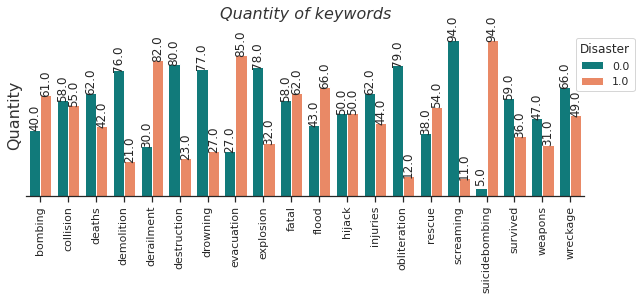

In [ ]:
plt.figure(figsize=(10,3))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='keyword',
                 y='text', 
                  hue='target',
                 data=data_gr.query('keyword in @key'), palette=color_m)
for z in ax.patches: 
  ax.annotate('{0:,}'.format(round(z.get_height(),1)).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points', rotation='90')
plt.xticks(rotation='90')
plt.xlabel('')
# plt.xlabel('Keywords', size = 10, color='0.2')
ax.set_yticklabels('')
plt.yticks([]) 
plt.ylabel('Quantity', size = 16, color='0.2')
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1), title='Disaster')
plt.title('Quantity of keywords', size = 16, y=1.05, fontstyle='oblique', color='0.2' );

Посмотрим на целевую переменную

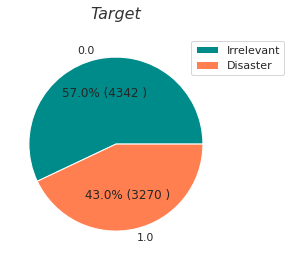

In [ ]:
df=clean_data[:7613].groupby('target').size()
# Make the plot with pandas
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)
ax=df.plot(kind='pie', subplots=True, figsize=(4, 4),   
                      autopct=lambda pct: func(pct, df),
                      colors=color_m)

plt.legend(labels=['Irrelevant', 'Disaster'],loc='upper right', bbox_to_anchor=(1.3,1))
plt.xlabel("")
plt.title("Target", size = 16, y=1.05, fontstyle='oblique', color='0.2' )
plt.ylabel("")
plt.show()

Выборка сбалансированная

In [ ]:
df=clean_data[:7613].groupby('target').size().reset_index()
df=df.rename(columns={0:'q'})
df

,target,q
0,0.0,4342
1,1.0,3271


##Посмотрим длину предложения

Токинизируем текст и отправляем в отдельный столбец

In [ ]:
#tokenize and put in special column
from nltk.tokenize import word_tokenize
def tok_text(tweets):
  return word_tokenize(tweets)
clean_data['tokens'] = clean_data['text'].apply(lambda x:tok_text(x))

In [ ]:
#check results
clean_data.head()

,keyword,location,text,target,krit,url,hashtags,location_clened,country_en,region_en,city_en,text_unite,tokens
id,,,,,,,,,,,,,
1,,,our deeds are the reason of this earetweethqu...,1.0,1,None,earthquake,,,,,The theme is It is in our deeds are the re...,"[our, deeds, are, the, reason, of, this, earet..."
4,,,forest fire near la ronge sask canada,1.0,1,None,,,,,,The theme is It is in forest fire near la ...,"[forest, fire, near, la, ronge, sask, canada]"
5,,,all residents asked to shelter in place are ...,1.0,1,None,,,,,,The theme is It is in all residents asked ...,"[all, residents, asked, to, shelter, in, place..."
6,,,13 000 people receive wildfires evacuation or...,1.0,1,None,wildfires,,,,,The theme is It is in 13 000 people receiv...,"[13, 000, people, receive, wildfires, evacuati..."
7,,,just got sent this photo from ruby alaska as ...,1.0,1,None,"Alaska,wildfires",,,,,The theme is It is in just got sent this p...,"[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
def len_tok(sent):
  return len(sent)
#text lenght for all together
print("===================text lenght for all together=======================")
print('Max sentence lenght for train and test together - ', np.max(clean_data['tokens'].apply(lambda x:len_tok(x))))
print('Mean sentence lenght for train and test together - ',np.mean(clean_data['tokens'].apply(lambda x:len_tok(x))))
print('Min sentence lenght for train and test together - ',np.min(clean_data['tokens'].apply(lambda x:len_tok(x))))
print('Median sentence lenght for train and test together - ',np.median(clean_data['text'].apply(lambda x:len_tok(x))))
#for train
print("===================text lenght for train=======================")
print('Max sentence lenght for train - ', np.max(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
print('Mean sentence lenght for train - ',np.mean(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
print('Min sentence lenght for train - ',np.min(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
print('Median sentence lenght for train - ',np.median(clean_data.query('krit==1')['text'].apply(lambda x:len_tok(x))))
#for test
print("===================text lenght for test=======================")
print('Max sentence lenght for test - ', np.max(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
print('Mean sentence lenght for test - ',np.mean(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
print('Min sentence lenght for test - ',np.min(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
print('Median sentence lenght for test - ',np.median(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
#for disaster
print("===================text lenght for disastert=======================")
print('Max sentence lenght for disaster - ', np.max(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
print('Mean sentence lenght for disaster - ',np.mean(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
print('Min sentence lenght for disaster - ',np.min(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
print('Median sentence lenght for disaster - ',np.median(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
#for NONdisaster
print("===================text lenght for  NONdisaster=======================")
print('Max sentence lenght for irrelevant - ', np.max(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
print('Mean sentence lenght for irrelevant - ',np.mean(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
print('Min sentence lenght for irrelevant - ',np.min(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
print('Median sentence lenght for irrelevant - ',np.median(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))

===================text lenght for all together=======================
Max sentence lenght for train and test together -  36
Mean sentence lenght for train and test together -  14.48344979771975
Min sentence lenght for train and test together -  1
Median sentence lenght for train and test together -  87.0
===================text lenght for train=======================
Max sentence lenght for train -  36
Mean sentence lenght for train -  14.474320241691842
Min sentence lenght for train -  1
Median sentence lenght for train -  87.0
===================text lenght for test=======================
Max sentence lenght for test -  35
Mean sentence lenght for test -  14.504750229849831
Min sentence lenght for test -  1
Median sentence lenght for test -  14.0
===================text lenght for disastert=======================
Max sentence lenght for disaster -  34
Mean sentence lenght for disaster -  14.736777743809233
Min sentence lenght for disaster -  1
Median sentence lenght for disaster -  

Создадим табличку, чтобы потом построить график

In [ ]:
tweet_lenght=pd.DataFrame()
lt=[]
lt.append(np.max(clean_data['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.mean(clean_data['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.min(clean_data['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.median(clean_data['tokens'].apply(lambda x:len_tok(x))))
tweet_lenght['general']=lt
lt=[]
lt.append(np.max(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.mean(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.min(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.median(clean_data.query('krit==1')['tokens'].apply(lambda x:len_tok(x))))
tweet_lenght['train']=lt
lt=[]
lt.append(np.max(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.mean(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.min(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.median(clean_data.query('krit==0')['tokens'].apply(lambda x:len_tok(x))))
tweet_lenght['test']=lt
lt=[]
lt.append(np.max(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.mean(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.min(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.median(clean_data.query('krit==1 and target==1')['tokens'].apply(lambda x:len_tok(x))))
tweet_lenght['disaster']=lt
lt=[]
lt.append(np.max(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.mean(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.min(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
lt.append(np.median(clean_data.query('krit==1 and target==0')['tokens'].apply(lambda x:len_tok(x))))
tweet_lenght['irrelevant']=lt
tweet_lenght['indicator']=['max', 'mean', 'min', 'median']

In [ ]:
tweet_lenght=tweet_lenght.reset_index().set_index('indicator')
tweet_lenght=tweet_lenght.unstack().reset_index()
tweet_lenght

In [ ]:
tweet_lenght.drop(labels=[0,1,2,3], axis=0, inplace=True)
tweet_lenght

строим график частоты слов

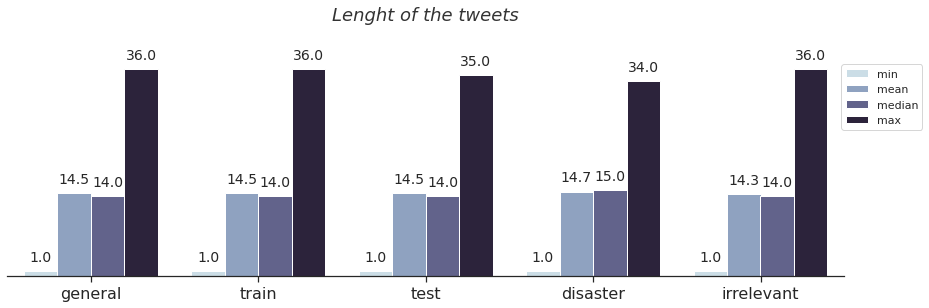

In [ ]:
fig = plt.figure(figsize=(15, 4)) 
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax=sns.barplot(x='level_0', y=0, hue='indicator', data=tweet_lenght, \
            hue_order=['min','mean','median', 'max'], palette='ch:s=.25,rot=-.25')
for z in ax.patches: 
  ax.annotate('{0:,}'.format(round(z.get_height(),1)).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 14), 
                   size=14, 
                   textcoords = 'offset points')
plt.xticks( size=16 )
plt.xlabel('')
plt.ylabel('')

ax.set_yticklabels('')
plt.yticks([]) 
# plt.ylabel('Quantity', size = 16, color='0.2')
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1))
plt.title('Lenght of the tweets', size = 18, y=1.15, fontstyle='oblique', color='0.2' );
plt.show()

Нарисуем распределение по длинне сообщения

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in clean_data['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_data['tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

157522 words total, with a vocabulary size of 18028
Max sentence length is 36


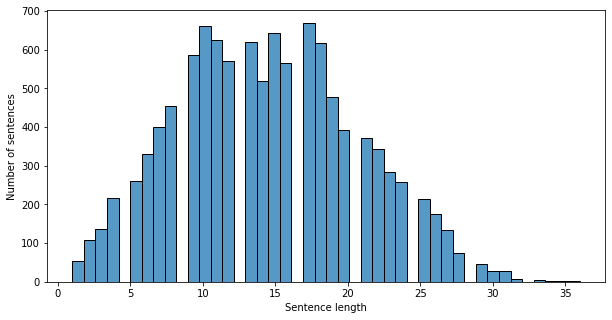

In [ ]:
fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
sns.histplot(sentence_lengths, palette="flare")
plt.show()

##Построим графики наиболее часто встречающихся слов в tweets о катастрофах и tweets не о катастрофах

Про катастрофы

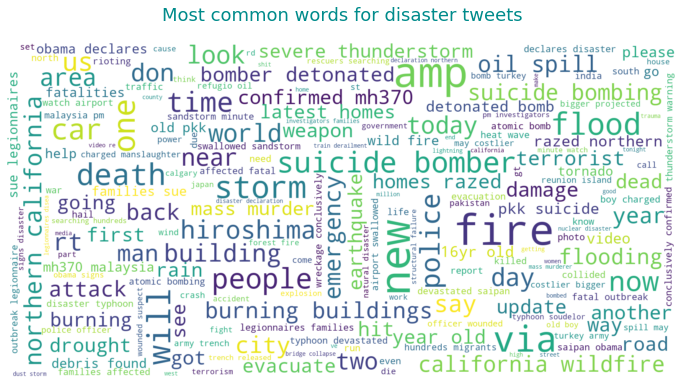

In [ ]:
#Disaster Tweets wordcloud 
disaster_tweets = clean_data[clean_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most common words for disaster tweets', size=18, color='darkcyan', y=1.05)
plt.show()

Про НЕ катастрофы

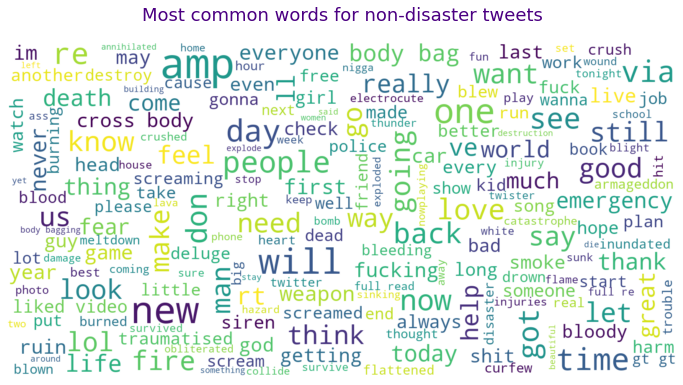

In [ ]:
#Non Disaster Tweets wordcloud 
disaster_tweets = clean_data.query('target == 0 and krit==1')
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most common words for non-disaster tweets', size=18, color='indigo', y=1.05)
plt.show()

## Проанализируем слова при помощи векторайзера

CountVectorizer — это простой способ векторизовать и представлять текстовые документы. Он токенизирует входные данные и строит словарь известных слов, а затем представляет документ, используя этот словарь.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_data[:7613]["text"].tolist()
list_labels = clean_data[:7613]["target"].tolist()

X_train_counts, count_vectorizer = cv(list_corpus)

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

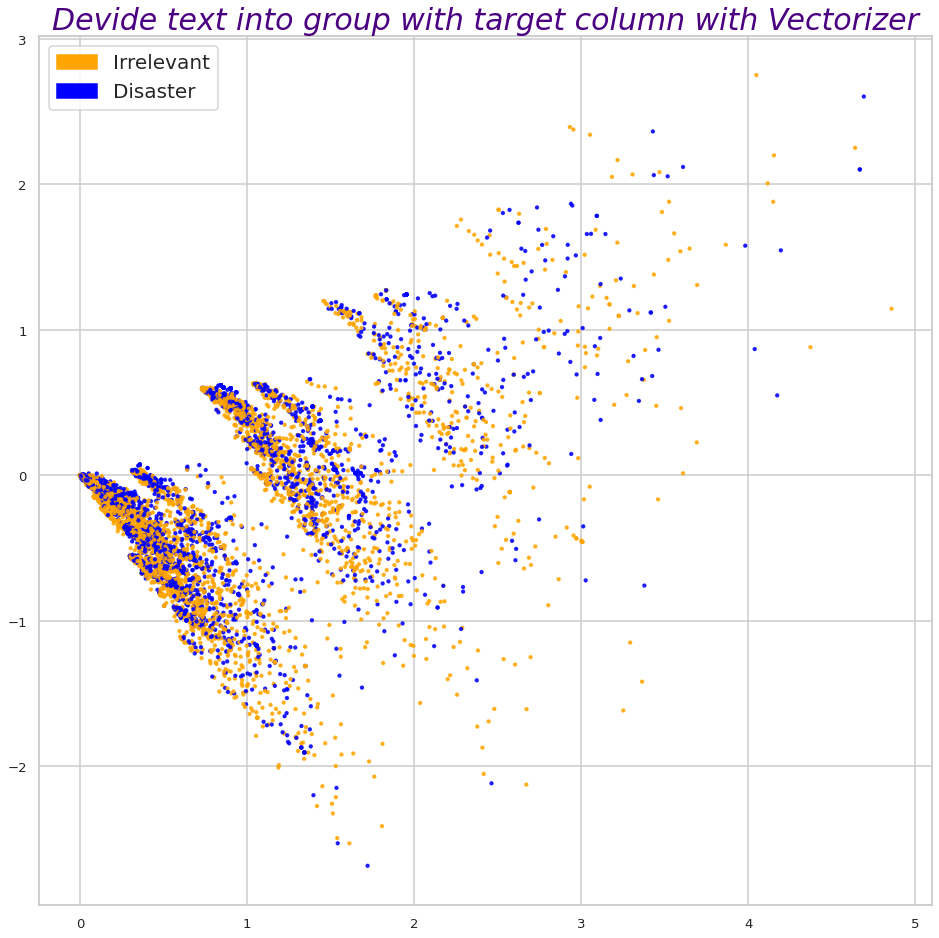

In [ ]:
def plot_res(X_train, labels, text):
  pca=TruncatedSVD(n_components=2)
  x= pca.fit_transform(X_train)
  color_mapper = {label:idx for idx,label in enumerate(set(labels))}
  color_column = [color_mapper[label] for label in labels]
  colors = ['orange','blue','blue']
  fig = plt.figure(figsize=(16, 16))
  sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=0.8, color_codes=False, palette='husl')
  plt.scatter(x[:,0], x[:,1], s=8, alpha=.8, c= labels, cmap=matplotlib.colors.ListedColormap(colors))
  red_patch = mpatches.Patch(color='orange', label='Irrelevant')
  green_patch = mpatches.Patch(color='blue', label='Disaster')
  plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
  plt.title('Devide text into group with target column '+ text, size=30, fontstyle='oblique', color='indigo')
  plt.show()

plot_res(X_train_counts, list_labels, text='with Vectorizer')  

## Попробуем разделить слова по принципу TF IDF. 
Т.е. по принципу - inversed document frequency- принципу встречаемости слова в документе. Слова, которые наиболее часто встречаются имеют наименьший вес для определения принадлежности текста к классу.

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(list_corpus)


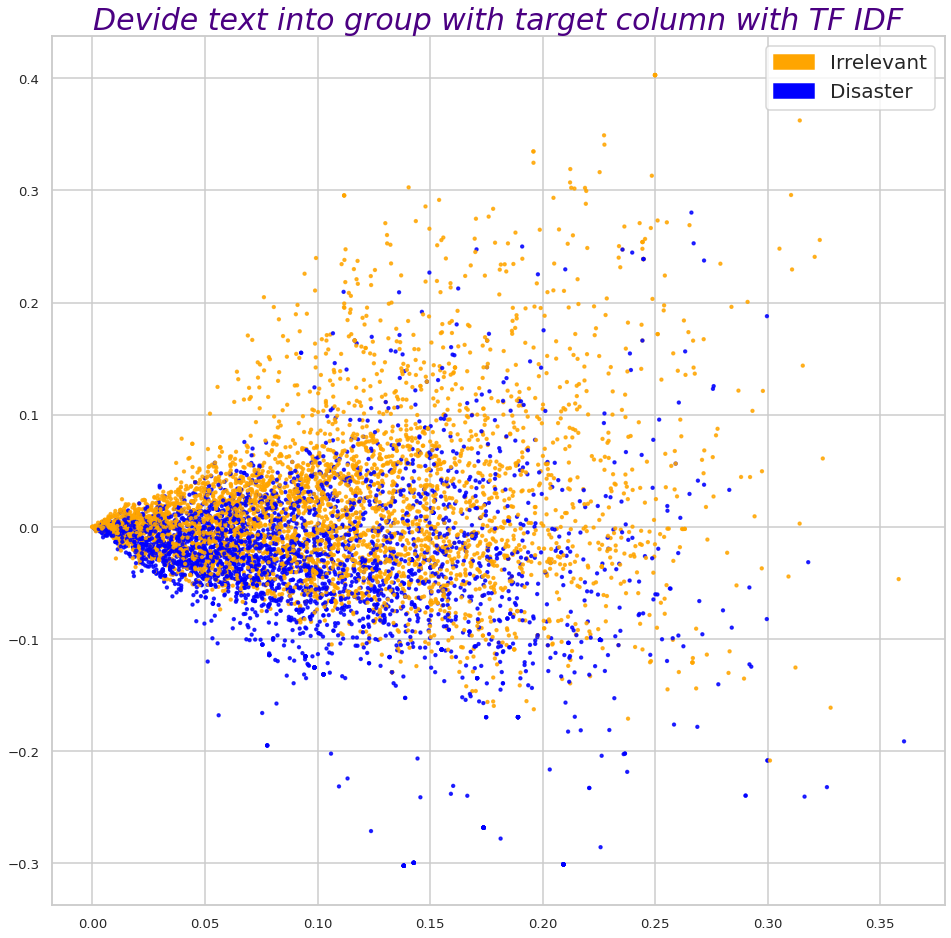

In [ ]:
plot_res(X_train_tfidf, list_labels, text='with TF IDF')

# Создаем новые столбцы

# Объединяем столбцы

В тексте явно присутствуют категориальные фичи. Это location и keyword. Попробуем включить их в анализ

In [ ]:
clean_data=clean_data.fillna(' ')

In [ ]:
clean_data['text_unite']='The theme is '+clean_data['keyword'].astype(str)+' It is in '+clean_data['location'].astype(str)+' '+clean_data['text'].astype(str)

## Проверим как разделяются данные на новом столбце

Векторайзер

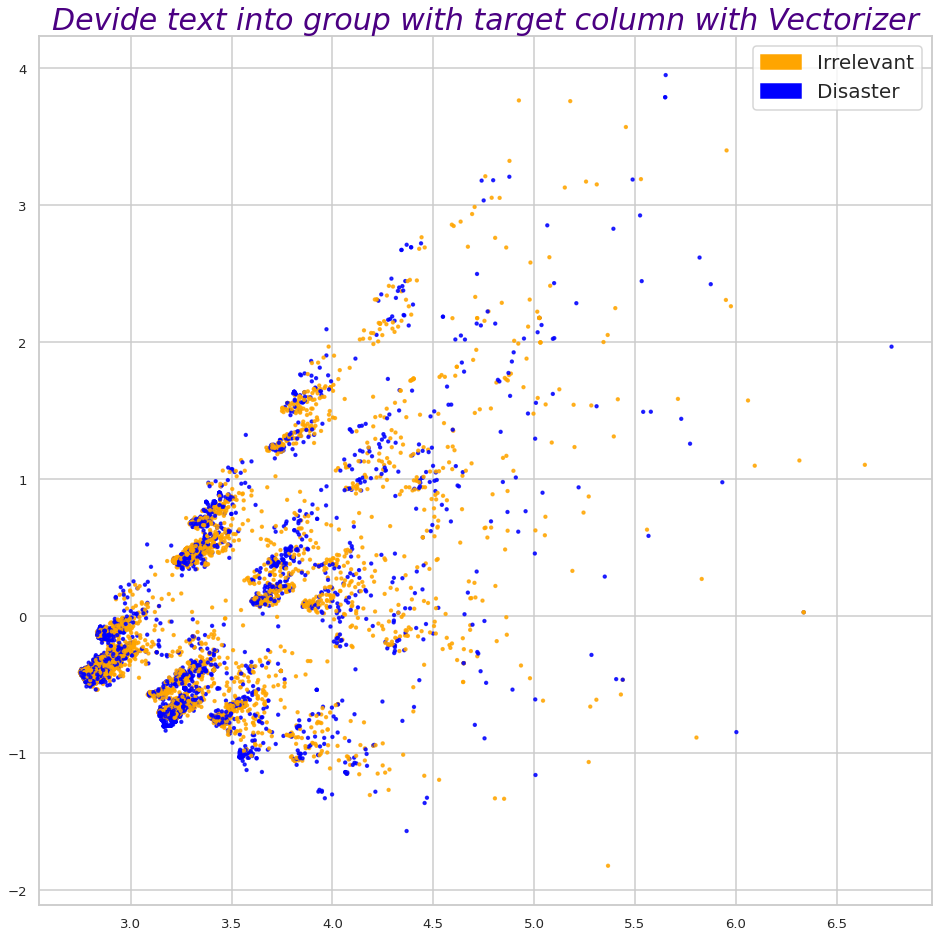

In [ ]:
#divide
list_corpus = clean_data[:7613]["text_unite"].tolist()
list_labels = clean_data[:7613]["target"].tolist()
#vectorize
X_train_counts, count_vectorizer = cv(list_corpus)
#plot
plot_res(X_train_counts, list_labels, text='with Vectorizer')  

IT IDF

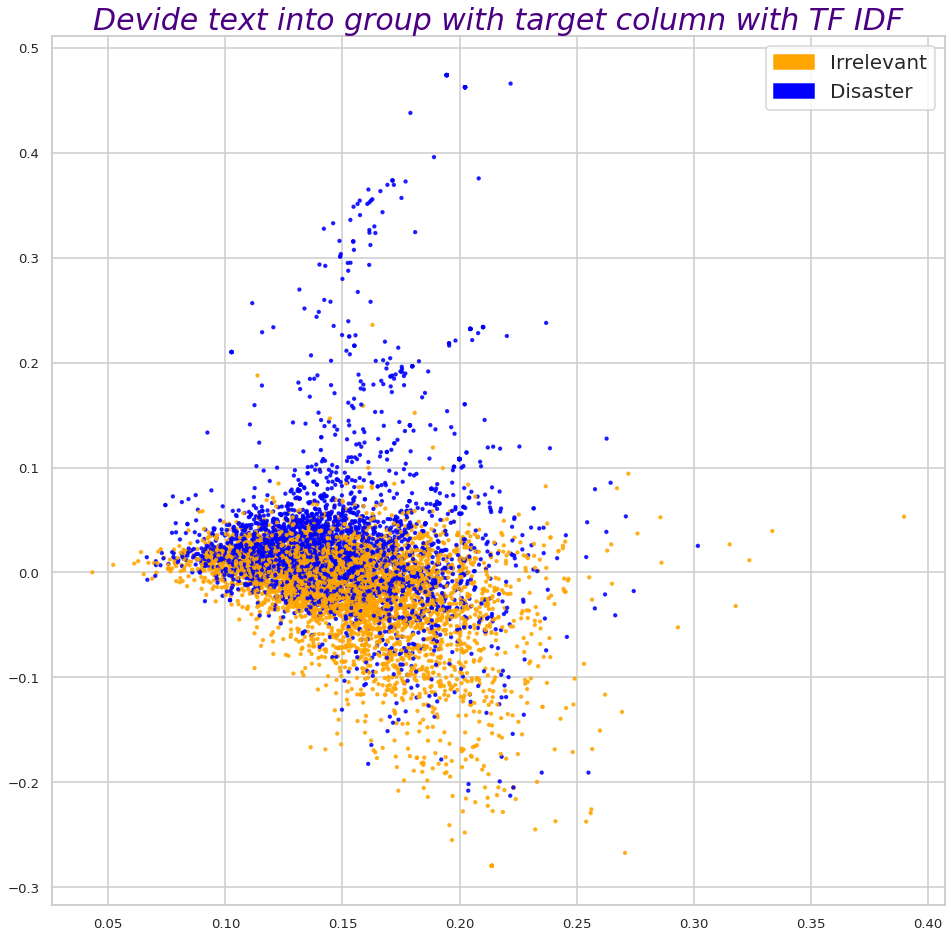

In [ ]:
#apply it idf
X_train_tfidf, tfidf_vectorizer = tfidf(list_corpus)
#plot
plot_res(X_train_tfidf, list_labels, text='with TF IDF') 

Вывод: данные стали чуть более разделимы